# Week 6 homeworks - God Spiked the Integers (chapter 11)

In [20]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

warnings.simplefilter(action="ignore", category=FutureWarning)
sns.set(context="notebook", font_scale=1.2, rc={"figure.figsize": (12, 5)})
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


*1. The data in NWOGrants.csv are outcomes for scientific funding applications for the Netherlands Organization for Scientic Research (NWO) from 2010–2012 (see [van der Lee and Ellemers](https://www.pnas.org/content/112/40/12349)). These data have a very similar structure to the UCBAdmit data discussed in Chapter 11.*

*I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through discipline. Draw the corresponding DAG and then use one or more binomial GLMs to answer the question.*

*What is your causal interpretation? If NWO’s goal is to equalize rates of funding between the genders, what type of intervention would be most effective?*

The implied DAG is:

![NWO DAG](img/nwo-dag.png)

where G is gender, D is discipline, and A is award. The direct causal effect of gender is the path G → A. The total effect includes that path and the indirect path G → D → A. We can estimate the total causal influence (assuming this DAG is correct) with a model that conditions only on gender. I’ll use a $Normal(-1, 1)$ prior for the intercepts, because we know from domain knowledge that less than half of applicants get awards.

Let's load the data and run this first total-effect model:

In [14]:
nwo = pd.read_csv("../Data/NWOGrants.csv", sep=";")
discipline_id, disciplines = nwo.discipline.factorize()
gender_id, genders = nwo.gender.factorize()
nwo

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


In [17]:
with pm.Model() as m_total:
    a = pm.Normal("a", -1.0, 1.0, shape=len(genders))

    p = pm.math.invlogit(a[gender_id])

    A = pm.Binomial("A", p=p, n=nwo.applications, observed=nwo.awards)

    trace_total = pm.sample(1000, tune=2000, cores=4, chains=2, random_seed=RANDOM_SEED)

post_total = pm.trace_to_dataframe(trace_total)
az.summary(trace_total, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 840.54draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.53,0.06,-1.63,-1.43,0.0,0.0,2050.79,2045.88,2057.33,1472.56,1.0
a[1],-1.74,0.08,-1.86,-1.61,0.0,0.0,2105.18,2094.39,2113.60,1466.49,1.0


Gender 0 here is male and 1 is female. So males have higher rates of award, on average. How big is the difference? Let’s look at the contrast on absolute scale:

In [28]:
diff = logistic(post_total["a__0"]) - logistic(post_total["a__1"])
print(f"Mean diff: {diff.mean().round(2)}")
print(f"89% HPD: {az.hpd(diff, credible_interval=0.89).round(2)}")

Mean diff: 0.03
89% HPD: [0.01 0.05]


So a small 3% difference on average. Still, with such low funding rates (in some disciplines), 3% is a big advantage.

Now for the direct influence of gender, we condition on discipline as well:

In [33]:
with pm.Model() as m_direct:
    aG = pm.Normal("aG", -1.0, 1.0, shape=len(genders))
    aD = pm.Normal("aD", 0.0, 1.0, shape=len(disciplines))

    p = pm.math.invlogit(aG[gender_id] + aD[discipline_id])

    A = pm.Binomial("A", p=p, n=nwo.applications, observed=nwo.awards)

    trace_direct = pm.sample(
        1000,
        tune=2000,
        cores=4,
        chains=2,
        random_seed=RANDOM_SEED,
        nuts_kwargs={"target_accept": 0.9},
    )

post_direct = pm.trace_to_dataframe(trace_direct)
az.summary(trace_direct, credible_interval=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [aD, aG]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:34<00:00, 173.09draws/s]
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
aG[0],-1.35,0.29,-1.83,-0.89,0.01,0.01,408.65,395.56,413.03,485.91,1.0
aG[1],-1.49,0.30,-1.94,-1.00,0.01,0.01,422.23,409.09,423.84,560.51,1.0
aD[0],0.33,0.34,-0.21,0.87,0.01,0.01,567.03,551.82,569.27,731.04,1.0
aD[1],-0.01,0.34,-0.52,0.57,0.01,0.01,520.46,520.46,520.54,647.63,1.0
aD[2],0.30,0.38,-0.26,0.92,0.02,0.01,628.02,628.02,626.38,864.34,1.0
aD[3],-0.23,0.32,-0.77,0.24,0.01,0.01,457.68,457.68,461.52,547.66,1.0
aD[4],-0.20,0.32,-0.72,0.31,0.01,0.01,488.26,488.26,487.07,782.87,1.0
aD[5],-0.27,0.34,-0.81,0.27,0.02,0.01,515.42,515.42,517.58,688.62,1.0
aD[6],0.01,0.32,-0.50,0.55,0.02,0.01,454.72,454.72,455.49,638.40,1.0
aD[7],-0.45,0.30,-0.91,0.05,0.01,0.01,431.11,431.11,435.36,592.12,1.0


Those chains didn’t sample very efficiently. This is likely because the model is over-parameterized -- it has more parameters than absolutely necessary. This doesn’t break it. It just makes the sampling less efficient. Anyway, now we can compute the gender difference again:

In [41]:
diff = logistic(post_direct["aG__0"]) - logistic(post_direct["aG__1"])
print(f"Mean diff: {diff.mean().round(2)}")
print(f"89% HPD: {az.hpd(diff, credible_interval=0.89).round(3)}")

Mean diff: 0.02
89% HPD: [-0.004  0.052]


Still an advantage for the males, but reduced and overlapping zero a bit. To see this difference on the absolute scale, we need to account for the base rates in each discipline as well.

In [59]:
p_g = pd.DataFrame(index=["m", "f"], columns=disciplines)
for d in disciplines:
    p_g[d] = (
        nwo.loc[nwo.discipline == d, "applications"]
        / nwo.loc[nwo.discipline == d, "applications"].sum()
    ).values
p_g.round(2)

,Chemical sciences,Physical sciences,Physics,Humanities,Technical sciences,Interdisciplinary,Earth/life sciences,Social sciences,Medical sciences
m,0.68,0.78,0.88,0.58,0.75,0.57,0.55,0.51,0.49
f,0.32,0.22,0.12,0.42,0.25,0.43,0.45,0.49,0.51


In [62]:
nwo["p_awards"] = nwo.awards / nwo.applications

,discipline,gender,applications,awards,p_awards
0,Chemical sciences,m,83,22,0.265060
1,Chemical sciences,f,39,10,0.256410
2,Physical sciences,m,135,26,0.192593
3,Physical sciences,f,39,9,0.230769
4,Physics,m,67,18,0.268657
5,Physics,f,9,2,0.222222
6,Humanities,m,230,33,0.143478
7,Humanities,f,166,32,0.192771
8,Technical sciences,m,189,30,0.158730
9,Technical sciences,f,62,13,0.209677


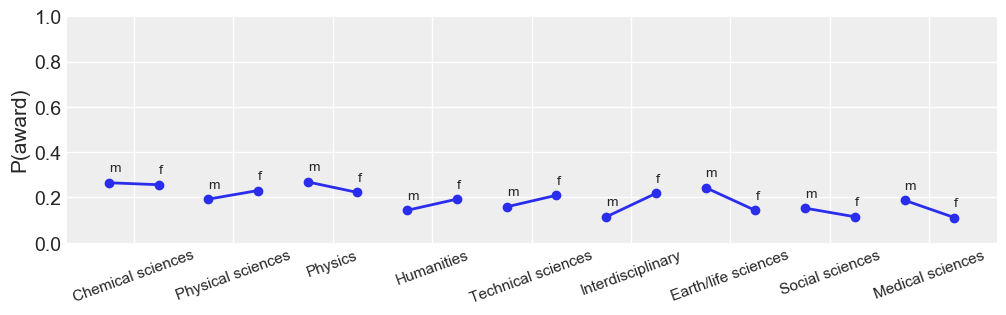

In [87]:
plt.figure(figsize=(12, 3))
tick_locs = []
for i in range(len(nwo) // 2):
    x = 2 * i  # keep i even
    y1 = nwo.p_awards[x]
    y2 = nwo.p_awards[x + 1]
    plt.plot([x, x + 1], [y1, y2], "-C0o", lw=2)
    plt.text(x, y1 + 0.05, nwo.gender[x], fontsize=10)
    plt.text(x + 1, y2 + 0.05, nwo.gender[x + 1], fontsize=10)
    tick_locs.append(x + 0.5)
plt.xticks(tick_locs, disciplines.values, rotation=20, fontsize=11)
plt.ylabel("P(award)")
plt.ylim(0, 1)

In [89]:
with m_direct:
    pm.sample_posterior_predictive(trace_direct)

100%|██████████| 2000/2000 [00:10<00:00, 192.24it/s]
